In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### add command path

In [2]:
import sys,numpy,pandas,os
from copy import deepcopy
sys.path.append('/home/heyangle/Desktop/ScanCraft/ScanCraft')

### import functions

In [3]:
from command.nexus.SPheno import SPheno,block_mapping
from command.scan.scan import scan
from command.multi_thread.MT_SPheno import MT_SPheno
from command.multi_thread.queue_operation import GenerateQueue # generate random queue
from command.pytorch.normalize import normalize
from command.operators.iterable import FlatToList
from command.data_transformer.ArrayToInputQueue import ArrayToInputQueue
from command.data_transformer.InputToPandas import InputToPandas
from command.data_transformer.defult_parameter_order import defult_name_order


In [4]:
mold=scan(method='random')
# MinPar
mold.AddScalar('tanB','MINPAR',3,1.,60.)
# Extpar
mold.AddScalar('Lambda','EXTPAR'  ,61  ,1e-3    ,1. ,prior_distribution='exponential')
mold.AddScalar('Kappa','EXTPAR'   ,62 ,1.e-3    ,1. ,prior_distribution='exponential')
mold.AddScalar('A_Lambda','EXTPAR' ,63,-3.e3,3.e3)
mold.AddScalar('A_kappa','EXTPAR' ,64,-3.e3,3.e3)
mold.AddScalar('mu_eff','EXTPAR'  ,65,100.,1500.)
# Squark mass
mold.AddElement( 'Mq32','MSQ2',(3,3),1e4,4e6)
mold.AddElement( 'Mu32','MSU2',(3,3),1e4,4e6)
mold.AddFollower('Md32','MSD2',(3,3),'Mu32')
# Slepton mass
mold.AddElement( 'Ml32','MSL2',(3,3),1e4,4e6)
mold.AddFollower('Ml22','MSL2',(2,2),'Ml32')
mold.AddFollower('Ml12','MSL2',(1,1),'Ml32')
mold.AddFollower('Me32','MSE2',(3,3),'Ml32')
mold.AddFollower('Me22','MSE2',(2,2),'Ml32')
mold.AddFollower('Me12','MSE2',(1,1),'Ml32')
# Yukawa
mold.AddElement( 'Tt' ,'TU'  ,(3,3),-2000,2000)
mold.AddElement( 'Tb' ,'TD'  ,(3,3),-2000,2000)
mold.AddElement( 'Ttau' ,'TE'  ,(3,3),-2000,2000)
# MSoft
mold.AddScalar('M1','MSOFT',1,50,2000)
mold.AddScalar('M2','MSOFT',2,100,2000)

In [5]:
mold.GetValue('LesHouches.in.NMSSM_low',mapping=block_mapping)
mold.Print()

      Mu32: 1000000.0
        Tt: 1000.0
        Tb: 1000.0
      Md32: 1000000.0
      Ttau: 0.0
      Mq32: 1000000.0
      Ml22: 40000.0
     Kappa: 0.11
      Ml32: 40000.0
        M1: 500.0
      Me32: 40000.0
      Me12: 40000.0
    Lambda: 0.1
      Ml12: 40000.0
        M2: 2000.0
      tanB: 10.0
      Me22: 40000.0
    mu_eff: 965.0
   A_kappa: -36.0
  A_Lambda: -1500.0


In [6]:
order=defult_name_order(mold.free_parameter_list)
order

['tanB',
 'Lambda',
 'Kappa',
 'A_Lambda',
 'A_kappa',
 'mu_eff',
 'M1',
 'M2',
 'Mq32',
 'Mu32',
 'Ml32',
 'Tt',
 'Tb',
 'Ttau']

In [7]:
dimention=len(order)
dimention

14

### normalize & tabulate parameters from mold list to numpy array

In [8]:
Norm=normalize(mold,order=order) # set operation scale=(a,b) to scale parameters to (a,b) range
Norm.scale

(0, 1)

### make a input point queue
*choose one*

In [8]:
# Random points queue by scan's function: Sample
RandSamples=GenerateQueue(mold,lenth=1000) 

In [19]:
# # Random points queue from numpy.random array
# normal_array=numpy.random.rand(1000,dimention) 
# par_array=Norm.D(normal_array)
# RandSamples=ArrayToInputQueue(par_array,mold,order=order)

### multithread SPheno

In [9]:
MTS=MT_SPheno(threads=6,Renew=False)

SPheno file:
->/home/heyangle/Desktop/ScanCraft/ScanCraft/packages/SPheno-4.0.3


In [9]:
MTS.Run(RandSamples,report_interval=1000)#,ReMake='NMSSM_sarah')

Calculations begin at Tue Jun 26 17:05:34 2018
  threads:	6
  points:	1000
Thread-3 got 0 samples
Thread-0 got 0 samples
Thread-2 got 0 samples
Thread-5 got 0 samples
Thread-4 got 0 samples
Thread-1 got 0 samples
  thread-5	runing,        0 points left at Tue Jun 26 17:16:17 2018
All points done. Use 0.183557 hours


KeyError: 'spectrum'

*# read from record*

In [13]:
output_dir=MTS.harvest_dir
os.listdir(output_dir)

['record_180626_171635']

#### or read original samples

In [10]:
from command.file_operations.GetSamples import GetSamples
samples=GetSamples(path='./output/record_180626_171635/',patterns=['in','out'])
spectr_list=[]
point_list=[]
for sample in samples:
    if len(sample.documents)==2:
        sample.Merge(SPheno.Read(None,sample.documents['out']))
        spectr_list.append(sample)
        inp=deepcopy(mold)
        inp.GetValue(sample.documents['in'],mapping=block_mapping)
        point_list.append(inp)
print(len(spectr_list),len(point_list))

167 167


In [11]:
g_0=InputToPandas(point_list,order=order,title='generation_1')
g_0[:3]

title generation_1                                                             \
block       MINPAR    EXTPAR                                                    
code             3        61        62           63           64           65   
name          tanB    Lambda     Kappa     A_Lambda      A_kappa       mu_eff   
0        27.672458  0.102620  0.131107   734.236108 -1210.995832  1182.715130   
1         2.924756  0.076024  0.169675  1173.376164  -235.757940   858.518302   
2        53.664279  0.111940  0.194700 -1112.492015 -2280.884011  1354.994362   

title                                                                      \
block        MSOFT                       MSQ2          MSU2          MSL2   
code             1            2        (3, 3)        (3, 3)        (3, 3)   
name            M1           M2          Mq32          Mu32          Ml32   
0      1760.206984   706.768164  2.171380e+06  1.906731e+06  1.692713e+06   
1      1464.288135  1821.644835  2.907816e+06  3.784579e+05  3.215624e+06   
2        87.046530   662.821565  1.593503e+06  9.059607e+05  2.974304e+06   

title                                         
block           TU           TD           TE  
code        (3, 3)       (3, 3)       (3, 3)  
name            Tt           Tb         Ttau  
0        95.973483  1600.336209 -1005.868844  
1     -1799.516104  -639.962608   939.381852  
2      1882.305604   827.384057 -1165.733023

In [12]:
g_0=Norm(g_0.values)
print(g_0.shape)

(167, 14)


### Chisqure

In [13]:
def Chisqure(sample):
    X2_h=(sample.MASS[25]-125.01)**2/9
    return X2_h

In [14]:
X2s=numpy.array(list(map(Chisqure,spectr_list))).reshape(-1,1)

In [15]:
# list(zip([s.MASS[25] for s in spectr_list],X2s))

In [16]:
X2s.shape

(167, 1)

### Gene Algorithm

In [21]:
from command.scan.GA import ga
Gene=ga()

In [22]:
storage_0=numpy.hstack([g_0,X2s])
storage_0

array([[4.52075558e-01, 1.01721262e-01, 1.30237003e-01, ...,
        9.00084052e-01, 2.48532789e-01, 1.42405098e+01],
       [3.26229821e-02, 7.50995170e-02, 1.68843451e-01, ...,
        3.40009348e-01, 7.34845463e-01, 2.23888903e+01],
       [8.92614901e-01, 1.11050911e-01, 1.93893965e-01, ...,
        7.06846014e-01, 2.08566744e-01, 7.11741385e-01],
       ...,
       [1.51528892e-01, 9.80710217e-02, 1.68710139e-01, ...,
        7.99404116e-01, 7.64570217e-01, 4.08845030e+00],
       [1.81368265e-01, 5.49474672e-02, 1.11703798e-01, ...,
        1.85166511e-01, 6.43496467e-02, 2.68420601e+00],
       [7.46505075e-01, 3.45552027e-02, 5.05670807e-03, ...,
        5.31274398e-01, 8.55113609e-01, 5.82979142e+02]])

In [23]:
Gene.Generation_new(storage_0[:100])

In [24]:
g_N1=Gene.Generation_Next()
g_N1=Norm.D(g_N1)
g_N1 # new generation to be calculated

array([[ 1.3928670e+01,  2.2987000e-03,  1.1226862e-01, ...,
         2.4940000e+02,  1.9284000e+02,  6.6780000e+02],
       [ 4.2296600e+00,  2.4836140e-02,  3.4848217e-01, ...,
        -1.6763200e+03,  1.2628000e+03, -4.0396000e+02],
       [ 2.7765350e+01,  4.3377580e-02,  3.2997970e-02, ...,
        -9.7672000e+02, -7.6160000e+02, -9.6700000e+02],
       ...,
       [ 1.1800540e+01,  8.8931980e-02,  9.9721180e-02, ...,
         2.1040000e+02,  1.5240000e+03,  8.5600000e+00],
       [ 3.4637670e+01,  2.5877197e-01,  4.3397659e-01, ...,
        -1.7263200e+03, -1.3422800e+03, -6.1440000e+02],
       [ 1.2254250e+01,  5.5715230e-02,  9.6993910e-02, ...,
         8.6876000e+02, -1.7620400e+03, -7.5100000e+02]])

In [26]:
newqueue=ArrayToInputQueue(g_N1,mold,order=order)

In [27]:
MTS.Run(newqueue)

Calculations begin at Fri Jun 29 14:03:49 2018
  threads:	6
  points:	100
Thread-2 got 0 samples
Thread-5 got 0 samples
Thread-0 got 0 samples
Thread-1 got 0 samples
Thread-4 got 0 samples
Thread-3 got 0 samples
  thread-2	runing,        0 points left at Fri Jun 29 14:08:49 2018
All points done. Use 0.089318 hours
85 sample recorded in ./output/record_180629_140911


In [32]:
X2s=numpy.array(list(map(Chisqure,MTS.sample_list))).reshape(-1,1)

In [1]:
import numpy

In [10]:
numpy.empty(shape=[1,3])

array([[4.9e-324, 9.9e-324, 1.5e-323]])

In [7]:
numpy.vstack([_5,numpy.array([1,2,3])])

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
%run ../SPheno_GA_scan.py

SPheno file:
->/home/heyangle/Desktop/ScanCraft/ScanCraft/packages/SPheno-4.0.3
Calculations begin at Thu Jul 12 12:36:06 2018
  threads:	6
  points:	100
Thread-2 got 0 samples
Thread-5 got 0 samples
Thread-1 got 0 samples
Thread-3 got 0 samples
Thread-0 got 0 samples
Thread-4 got 0 samples
  thread-2	runing,        0 points left at Thu Jul 12 12:36:47 2018
All points done. Use 0.016124 hours
14 sample recorded in ./output/record_180712_123704
Calculations begin at Thu Jul 12 12:37:04 2018
  threads:	6
  points:	100


In [12]:
len(sample_list)

51

In [14]:
len(X2s_list)

1

In [39]:
X2s_all=numpy.vstack(X2s_list).reshape(-1)
X2s_all

array([2.66760632e+05, 1.18045506e+06, 5.52061245e+06, ...,
       2.46764286e+05, 2.06382493e+04, 2.42500090e+01])

In [16]:
import matplotlib.pylab as plt

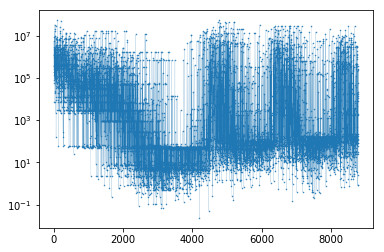

In [42]:
plt.semilogy(X2s_all,linewidth=0.1,marker='.',markersize=1)

In [43]:
min(X2s_all)

0.023647000411778134

In [37]:
def Chisqure(sample):
    X2_h=(sample.MASS[35]-125.01)**2/9
    X1_h=(sample.MASS[25]-95)**2/25
    return X2_h+X1_h

In [38]:
X2s_list=[]
for generation in range(0,51):
    X2s=numpy.array(list(map(Chisqure,sample_list[generation]))).reshape(-1,1)
    X2s_list.append(X2s)